In [31]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [32]:
df = pd.read_csv("phoneprices.csv")

df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,...,1222,1890,668,13,4,19,1,1,0,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2
1997,1911,0,0.9,1,1,1,36,0.7,108,8,...,868,1632,3057,9,1,5,1,1,0,3
1998,1512,0,0.9,0,4,1,46,0.1,145,5,...,336,670,869,18,10,19,1,1,1,0


In [33]:
x = df.iloc[:,:-1]

x_normalized = (x - x.min()) / (x.max() - x.min())

x_normalized

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,0.227789,0.0,0.68,0.0,0.052632,0.0,0.080645,0.555556,0.900000,0.142857,0.10,0.010204,0.170895,0.612774,0.285714,0.388889,0.944444,0.0,0.0,1.0
1,0.347361,1.0,0.00,1.0,0.000000,1.0,0.822581,0.666667,0.466667,0.285714,0.30,0.461735,0.993324,0.634687,0.857143,0.166667,0.277778,1.0,1.0,0.0
2,0.041416,1.0,0.00,1.0,0.105263,1.0,0.629032,0.888889,0.541667,0.571429,0.30,0.644388,0.811749,0.627205,0.428571,0.111111,0.388889,1.0,1.0,0.0
3,0.076152,1.0,0.80,0.0,0.000000,0.0,0.129032,0.777778,0.425000,0.714286,0.45,0.620408,0.858478,0.671566,0.785714,0.444444,0.500000,1.0,0.0,0.0
4,0.881764,1.0,0.28,0.0,0.684211,1.0,0.677419,0.555556,0.508333,0.142857,0.70,0.616327,0.475300,0.308658,0.214286,0.111111,0.722222,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.195725,1.0,0.00,1.0,0.000000,1.0,0.000000,0.777778,0.216667,0.714286,0.70,0.623469,0.927904,0.110102,0.571429,0.222222,0.944444,1.0,1.0,0.0
1996,0.977956,1.0,0.84,1.0,0.000000,0.0,0.596774,0.111111,0.891667,0.428571,0.15,0.466837,0.977971,0.474613,0.428571,0.555556,0.777778,1.0,1.0,1.0
1997,0.941884,0.0,0.16,1.0,0.052632,1.0,0.548387,0.666667,0.233333,1.000000,0.15,0.442857,0.755674,0.748530,0.285714,0.055556,0.166667,1.0,1.0,0.0
1998,0.675351,0.0,0.16,0.0,0.210526,1.0,0.709677,0.000000,0.541667,0.571429,0.25,0.171429,0.113485,0.163816,0.928571,0.555556,0.944444,1.0,1.0,1.0


In [34]:
y = pd.get_dummies(df.iloc[:,-1], prefix='y')

y

,y_0,y_1,y_2,y_3
0,0,1,0,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,1,0,0
...,...,...,...,...
1995,1,0,0,0
1996,0,0,1,0
1997,0,0,0,1
1998,1,0,0,0


In [35]:
x_train, x_test, y_train, y_test = train_test_split(x_normalized, y, test_size=0.3)

len_input = len(x_train.columns)
len_output = len(y_train.columns)

print("Len Input: {}".format(len_input))
print("Len Output: {}".format(len_output))

Len Input: 20
Len Output: 4


In [36]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
        self.n_samples = len(x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples

In [37]:
def one_hot_encoding(nd_array):
    one_hot_encoding_predictions = nd_array

    for i in range(len(nd_array)):
        max_pred = max(nd_array[i])

        for j in range(len(nd_array[i])):
            one_hot_encoding_predictions[i][j] = 1 if nd_array[i][j] == max_pred else 0

    return one_hot_encoding_predictions

In [38]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_1 = nn.Linear(input_dim, 25)
        self.input_2 = nn.Linear(25, 20)
        self.input_3 = nn.Linear(20, 10)
        self.output = nn.Linear(10, output_dim)

    def forward(self, x):
        # f(x) = a(f(x))
        x = F.relu(self.input_1(x))
        x = F.relu(self.input_2(x))
        x = F.relu(self.input_3(x))
        x = torch.sigmoid(self.output(x))
        y = F.softmax(x, dim=-1)

        return y

model = MultiLayerPerceptron(len_input, len_output)

In [39]:
def train_fn(loader, model, optimizer, loss_fn, device):
    loop = tqdm(loader)

    average_loss = 0
    count = 0
    
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        # Forward
        predictions = model.forward(data)
        
        predictions = F.softmax(predictions, dim=-1)
        
        loss = loss_fn(predictions, targets)
        
        # Backward
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        # Update tqdm
        loop.set_postfix(loss=loss.item())

        average_loss += loss.item()
        count += 1
    
    average_loss = average_loss / count

    return average_loss

In [40]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,299 trainable parameters


In [41]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

device = 'cpu'
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

batch_size = 5

epochs = 100

In [42]:
x_train = torch.tensor(x_train.values).float().to(device)
y_train = torch.tensor(y_train.values).float().to(device)

x_test = torch.tensor(x_test.values).float().to(device)
y_test = torch.tensor(y_test.values).float().to(device)

training_ds = CustomDataset(x_train, y_train)

train_loader = DataLoader(
    training_ds,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

torch.Size([1400, 20])
torch.Size([1400, 4])
torch.Size([600, 20])
torch.Size([600, 4])


In [43]:
# Convert y_test to numpy array
y_test = y_test.detach().cpu().numpy()

# Array to store the losses
losses = []

# Array to store accuracy score
accuracies = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    average_loss = train_fn(train_loader, model, optimizer, criterion, device)

    # Perform a prediction at every epoch
    one_hot_encoding_predictions = one_hot_encoding(
        model.forward(x_test).detach().cpu().numpy()
    )

    print(one_hot_encoding)

    # Get the accuracy at every epoch
    acc_score = accuracy_score(
        y_test,
        one_hot_encoding_predictions
    )

    losses.append(average_loss)

    accuracies.append(acc_score)

    print("Average Loss: {}".format(average_loss))
    print("Acc Score: {}".format(acc_score))

Epoch: 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 376.75it/s, loss=1.39]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3862783649138042
Acc Score: 0.24333333333333335
Epoch: 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 320.06it/s, loss=1.39]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3862607283251627
Acc Score: 0.24333333333333335
Epoch: 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 345.26it/s, loss=1.39]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3862382003239222
Acc Score: 0.24333333333333335
Epoch: 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 306.68it/s, loss=1.39]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3862084290810994
Acc Score: 0.24333333333333335
Epoch: 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 344.06it/s, loss=1.39]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3861644408532552
Acc Score: 0.24333333333333335
Epoch: 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 337.41it/s, loss=1.39]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3860625156334467
Acc Score: 0.24333333333333335
Epoch: 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 311.98it/s, loss=1.39]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3858117852892196
Acc Score: 0.24333333333333335
Epoch: 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 354.48it/s, loss=1.39]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3853628073419844
Acc Score: 0.24333333333333335
Epoch: 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 352.99it/s, loss=1.38]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3845543767724717
Acc Score: 0.24333333333333335
Epoch: 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 353.97it/s, loss=1.38]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3831498107739857
Acc Score: 0.30333333333333334
Epoch: 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 373.39it/s, loss=1.38]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3810650770153319
Acc Score: 0.4533333333333333
Epoch: 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 298.29it/s, loss=1.38]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3783621336732592
Acc Score: 0.6083333333333333
Epoch: 12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 299.57it/s, loss=1.37]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3753687781947
Acc Score: 0.645
Epoch: 13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 325.10it/s, loss=1.37]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3725818165710995
Acc Score: 0.67
Epoch: 14


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 367.29it/s, loss=1.37]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3702631333044597
Acc Score: 0.6666666666666666
Epoch: 15


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 311.26it/s, loss=1.37]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3684133610555105
Acc Score: 0.66
Epoch: 16


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 381.26it/s, loss=1.37]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.366942570890699
Acc Score: 0.6366666666666667
Epoch: 17


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 337.11it/s, loss=1.37]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3657523044518063
Acc Score: 0.5883333333333334
Epoch: 18


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 297.04it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3647618681192397
Acc Score: 0.535
Epoch: 19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 397.24it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3639176951987402
Acc Score: 0.52
Epoch: 20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 335.29it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.363187079344477
Acc Score: 0.53
Epoch: 21


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 356.21it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3625453697783607
Acc Score: 0.545
Epoch: 22


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 347.73it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3619726687669753
Acc Score: 0.57
Epoch: 23


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 383.90it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.361448974268777
Acc Score: 0.5866666666666667
Epoch: 24


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 379.85it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.360955626623971
Acc Score: 0.5916666666666667
Epoch: 25


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 375.81it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.360473968727248
Acc Score: 0.6066666666666667
Epoch: 26


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 399.75it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.359989480461393
Acc Score: 0.6266666666666667
Epoch: 27


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 379.73it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3594885166202273
Acc Score: 0.6316666666666667
Epoch: 28


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 324.18it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3589682894093649
Acc Score: 0.6283333333333333
Epoch: 29


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 414.08it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3584359828914916
Acc Score: 0.6366666666666667
Epoch: 30


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 372.22it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.357904436332839
Acc Score: 0.6283333333333333
Epoch: 31


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 409.34it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3573845126799176
Acc Score: 0.6266666666666667
Epoch: 32


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 420.47it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.356885552406311
Acc Score: 0.6166666666666667
Epoch: 33


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 402.22it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.356412491628102
Acc Score: 0.6066666666666667
Epoch: 34


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 355.63it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3559672551495687
Acc Score: 0.5916666666666667
Epoch: 35


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 369.00it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3555495066302163
Acc Score: 0.575
Epoch: 36


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 343.69it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3551574298313687
Acc Score: 0.54
Epoch: 37


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 362.06it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3547897504908697
Acc Score: 0.455
Epoch: 38


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 364.90it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3544439801148005
Acc Score: 0.45666666666666667
Epoch: 39


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 362.12it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3541193813085557
Acc Score: 0.45666666666666667
Epoch: 40


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 358.10it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.353813209278243
Acc Score: 0.45666666666666667
Epoch: 41


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 360.01it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3535234681197574
Acc Score: 0.45666666666666667
Epoch: 42


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 359.87it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3532501603875842
Acc Score: 0.45666666666666667
Epoch: 43


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 354.86it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3529914783579962
Acc Score: 0.4583333333333333
Epoch: 44


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 357.26it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3527457726853234
Acc Score: 0.4583333333333333
Epoch: 45


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 352.91it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3525132196290153
Acc Score: 0.46
Epoch: 46


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 359.09it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.352292197091239
Acc Score: 0.46
Epoch: 47


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 359.21it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3520819783210754
Acc Score: 0.46
Epoch: 48


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 348.14it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3518813295023782
Acc Score: 0.46
Epoch: 49


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 357.88it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3516904486077173
Acc Score: 0.46
Epoch: 50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 345.53it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3515084330524718
Acc Score: 0.4583333333333333
Epoch: 51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 357.32it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3513346101556505
Acc Score: 0.46
Epoch: 52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 355.69it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.351168634210314
Acc Score: 0.46
Epoch: 53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 348.63it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3510093820946558
Acc Score: 0.46
Epoch: 54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 339.99it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.350857235278402
Acc Score: 0.46
Epoch: 55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 348.37it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3507111004420689
Acc Score: 0.46
Epoch: 56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 360.94it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3505710176059178
Acc Score: 0.46166666666666667
Epoch: 57


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 361.64it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3504367381334306
Acc Score: 0.46166666666666667
Epoch: 58


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 336.53it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3503077702862876
Acc Score: 0.46166666666666667
Epoch: 59


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 340.25it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3501839395080293
Acc Score: 0.46166666666666667
Epoch: 60


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 353.42it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3500644398587092
Acc Score: 0.46166666666666667
Epoch: 61


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 355.21it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3499495859657016
Acc Score: 0.4633333333333333
Epoch: 62


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 360.93it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3498391721929823
Acc Score: 0.4633333333333333
Epoch: 63


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 360.33it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3497328013181686
Acc Score: 0.4633333333333333
Epoch: 64


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 362.24it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3496301152876444
Acc Score: 0.4633333333333333
Epoch: 65


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 359.69it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.349530566590173
Acc Score: 0.4633333333333333
Epoch: 66


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 350.52it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3494352868625097
Acc Score: 0.4633333333333333
Epoch: 67


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 348.30it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3493427319186075
Acc Score: 0.4633333333333333
Epoch: 68


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 349.64it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.34925400188991
Acc Score: 0.4633333333333333
Epoch: 69


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 356.17it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3491677624838694
Acc Score: 0.465
Epoch: 70


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 352.49it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3490847464118685
Acc Score: 0.465
Epoch: 71


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 357.01it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3490045300551823
Acc Score: 0.465
Epoch: 72


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 365.13it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.34892683667796
Acc Score: 0.465
Epoch: 73


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 349.17it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.348851780806269
Acc Score: 0.4666666666666667
Epoch: 74


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 355.01it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.348778999703271
Acc Score: 0.4683333333333333
Epoch: 75


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 338.58it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.348708656004497
Acc Score: 0.4683333333333333
Epoch: 76


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 354.79it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3486402234860828
Acc Score: 0.4683333333333333
Epoch: 77


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 359.62it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3485740610531398
Acc Score: 0.4683333333333333
Epoch: 78


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 355.53it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3485087330852237
Acc Score: 0.4683333333333333
Epoch: 79


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 353.26it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3484464930636542
Acc Score: 0.4683333333333333
Epoch: 80


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 332.75it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3483856669494083
Acc Score: 0.4683333333333333
Epoch: 81


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 345.53it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3483262658119202
Acc Score: 0.47
Epoch: 82


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 362.36it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3482703013079507
Acc Score: 0.47
Epoch: 83


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 348.55it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3482146561145782
Acc Score: 0.47
Epoch: 84


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 344.48it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3481607918228422
Acc Score: 0.47
Epoch: 85


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 344.87it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.348108217545918
Acc Score: 0.47
Epoch: 86


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 352.03it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.348057839700154
Acc Score: 0.47
Epoch: 87


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 341.61it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.348006449852671
Acc Score: 0.47
Epoch: 88


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 346.12it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3479591663394654
Acc Score: 0.47
Epoch: 89


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 342.70it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3479117240224565
Acc Score: 0.4716666666666667
Epoch: 90


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 347.52it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3478662473814829
Acc Score: 0.4716666666666667
Epoch: 91


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 346.15it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3478217669895718
Acc Score: 0.4716666666666667
Epoch: 92


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 343.33it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.34777857703822
Acc Score: 0.4716666666666667
Epoch: 93


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 357.05it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3477359499250139
Acc Score: 0.4716666666666667
Epoch: 94


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 340.30it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3476940589291708
Acc Score: 0.47333333333333333
Epoch: 95


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 365.16it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3476535597017834
Acc Score: 0.47333333333333333
Epoch: 96


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 348.69it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3476145033325468
Acc Score: 0.47333333333333333
Epoch: 97


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 345.57it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3475750965731486
Acc Score: 0.47333333333333333
Epoch: 98


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 347.07it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3475379011460713
Acc Score: 0.475
Epoch: 99


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 341.03it/s, loss=1.36]


<function one_hot_encoding at 0x7f334b75ce50>
Average Loss: 1.3475012063980103
Acc Score: 0.475


In [44]:
predictions = model.forward(x_test)

print(predictions.shape)

torch.Size([600, 4])


In [45]:
one_hot_encoding_predictions = one_hot_encoding(predictions.detach().cpu( ).numpy())

one_hot_encoding_predictions

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [46]:
accuracy = accuracy_score(y_test, one_hot_encoding_predictions)

print("Accuracy: {}".format(accuracy))

Accuracy: 0.475


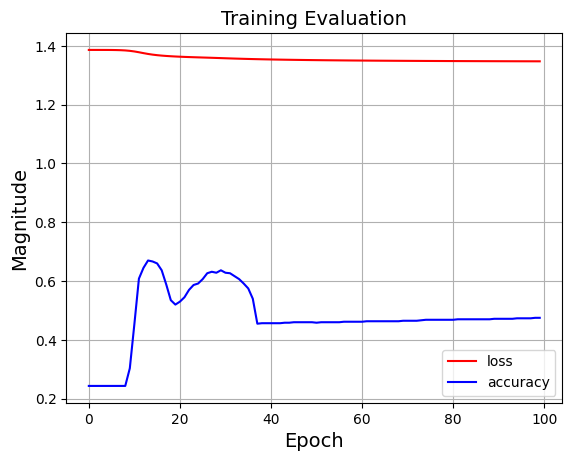

In [47]:
plt.plot(losses, label='loss', color='red')
plt.plot(accuracies, label='accuracy', color='blue')
plt.title('Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Magnitude', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()